In [1]:
from google.colab import drive

# the following command loads up your google drive. It will promp you to give Colab access to your Gdrive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import scipy
import plotly.express as px


data_path = '/content/drive/My Drive/AMATH482/HW1/subdata.npy'

In [3]:
# ---- From helper code ----
d = np.load(data_path) # huge matrix of size 262144 x 49 (columns contain flattened 3d matrix of size 64x64x64)

# plot the data in time 

L = 10; # length of spatial domain (cube of side L = 2*10)
N_grid = 64; # number of grid points/Fourier modes in each direction
xx = np.linspace(-L, L, N_grid+1) #spatial grid in x dir
x = xx[0:N_grid]
y = x # same grid in y,z direction
z = x

K_grid = (2*np.pi/(2*L))*np.linspace(-N_grid/2, N_grid/2 -1, N_grid) # frequency grid for one coordinate

xv, yv, zv = np.meshgrid( x, y, z) # generate 3D meshgrid for plotting
# ---- end of helper code ----

# Will store the sum of FFT for each measurement
fft_signal = 0

# Guidance from Katherine Owens in Discussion Board
# Reshape data into 64x64x64 cube
for j in range(0,49):
  signal = np.reshape(d[:, j], (N_grid, N_grid, N_grid))
  # Take FFT and add to sum
  fft_signal = fft_signal + np.fft.fftshift(np.fft.fftn(signal))

# Average FFT
fft_avg = np.abs(fft_signal / 49)

# Getting max frequency
fft_max = np.amax(fft_avg)
fft_max_arg = np.where(fft_avg == fft_max)
# Returns as Y, X, Z
print(fft_max_arg)
print(fft_avg[39, 49, 10])

(array([39]), array([49]), array([10]))
89.89652346622287


Text(0, 0.5, 'ky')

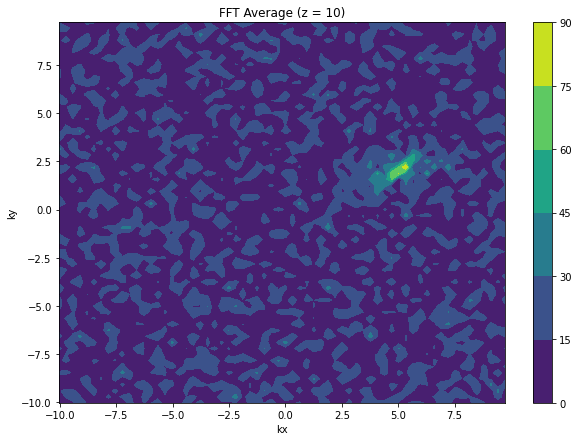

In [77]:
kx, ky = np.meshgrid(K_grid, K_grid)
# To look at different x-y slices
z_val = 10

fig1, ax1 = plt.subplots(figsize=(10,7))
im1 = ax1.contourf(kx, ky, abs(fft_avg[:,:,z_val]))
plt.colorbar(im1)
ax1.set_title("FFT Average (z = " + str(z_val) + ")")
# switched for some reason, to correspond with indices
ax1.set_xlabel("kx")
ax1.set_ylabel("ky")

In [5]:
# Create 3D Gaussian filter

x_shift = int(fft_max_arg[1] - 32) * (2*np.pi/(2*L))
y_shift = int(fft_max_arg[0] - 32) * (2*np.pi/(2*L))
z_shift = int(fft_max_arg[2] - 32) * (2*np.pi/(2*L))

def g(x, y, z, s):
  # center the filter on central frequency in averaged FFT
  val = np.exp( - ( (x - x_shift)**2 + (y - y_shift)**2 + (z - z_shift)**2 )/(2*s**2)  )
  return val

Text(0, 0.5, 'ky')

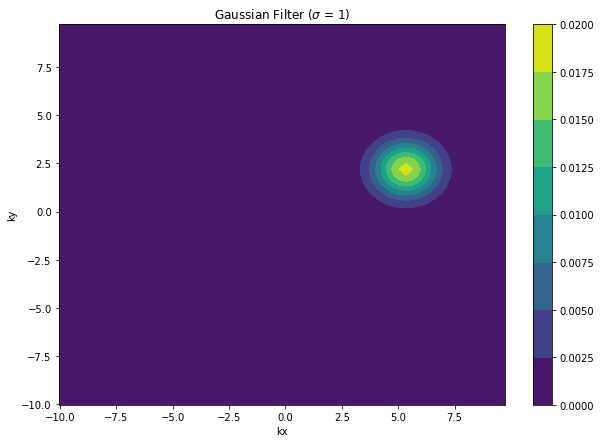

In [76]:
kx, ky, kz = np.meshgrid(K_grid, K_grid, K_grid)

sigma = 1
g_vals = g(kx, ky, kz, sigma)

fig2, ax2 = plt.subplots(figsize=(10,7))
im2 = ax2.contourf(kx[:,:,1], ky[:,:,1], g_vals[:,:,1])
plt.colorbar(im2)
ax2.set_title("Gaussian Filter ($\sigma$ = " + str(sigma) + ")")
ax2.set_xlabel("kx")
ax2.set_ylabel("ky")

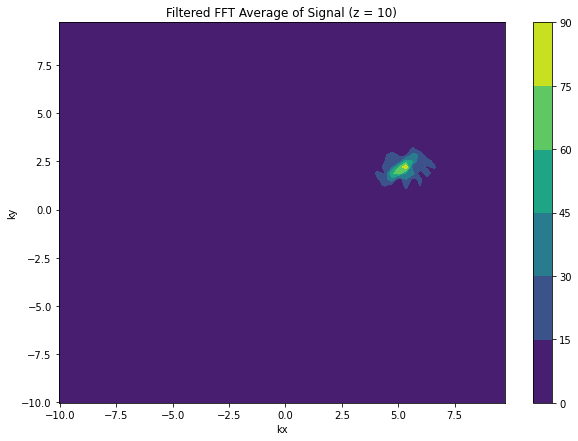

In [74]:
# Apply filter to FFT average
fft_avg_filtered = g_vals * fft_avg

# # Reconstruct signal
# signal_filtered = np.abs(np.real(np.fft.ifftn( np.fft.ifftshift(fft_signal_filtered) )))
# print(np.shape(signal_filtered))

# Plot filtered FFT average
kx, ky = np.meshgrid(K_grid, K_grid)
z_val = 10

fig3, ax3 = plt.subplots(figsize=(10,7))
im3 = ax3.contourf(kx, ky, np.abs(fft_avg_filtered[:,:,z_val]))
ax3.set_title("Filtered FFT Average of Signal (z = " + str(z_val) + ")")
ax3.set_xlabel("kx")
ax3.set_ylabel("ky")
plt.colorbar(im3)

In [73]:
# Store coordinates of submarine
x_sub = np.zeros(49)
y_sub = np.zeros(49)
z_sub = np.zeros(49)

# Filter signals for each time slice
for j in range(0,49): #loop over every time 
    signal = np.reshape(d[:, j], (N_grid, N_grid, N_grid))
    # Take FFT
    fft_signal = np.fft.fftshift(np.fft.fftn(signal))
    # Filter FFT
    fft_signal_filtered = fft_signal * g_vals
    # Inverse FFT to get filtered signal
    signal_filtered = np.real(np.fft.ifftn(np.fft.ifftshift(fft_signal_filtered)))
    # Get max frequency
    signal_max = np.amax(signal_filtered)
    # Location of max frequency is location of sub
    signal_max_arg = np.where(signal_filtered == signal_max)
    x_sub[j] = signal_max_arg[1]
    y_sub[j] = signal_max_arg[0]
    z_sub[j] = signal_max_arg[2]
    

Text(0, 0.5, 'Y')

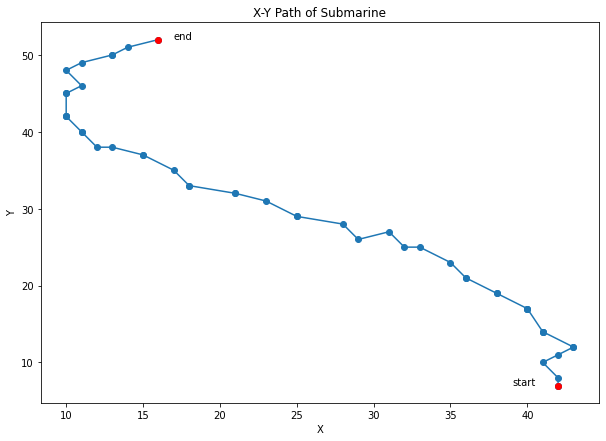

In [72]:
# Plotting 2D sub trajectory
fig4, ax4 = plt.subplots(figsize=(10,7))
ax4.plot(x_sub, y_sub, "o-")
ax4.plot([x_sub[0], x_sub[48]], [y_sub[0], y_sub[48]], "ro")
ax4.annotate("start", (39, y_sub[0]))
ax4.annotate("end", (17, y_sub[48]))
ax4.set_title("X-Y Path of Submarine")
ax4.set_xlabel("X")
ax4.set_ylabel("Y")

In [19]:
# Plotting 3D sub trajectory
fig5 = px.line_3d(x=x_sub, y=y_sub, z=z_sub, height=500, width=750, title="Submarine Path")
fig5.show()